# Continuous Optimisation HW2

In [1046]:
# Imports
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
from scipy.io import loadmat
import time


data = loadmat('data.mat')
data_toy = loadmat('data-toy.mat')

# Question 1
Implement phi(x, P), bigphi(X, P), f(X, P, y).

In [1047]:
# Question 1
#TODO Vectorise all the functions

def h(x: np.ndarray) -> float:
    """
    Gaussian filter

    :x: np.ndarray[(1, 2)]
    :returns: float
    """
    return np.e**(-np.inner(x, x)/sigmasquared)  # Always take sigma = 0.1


def phi(x,P):
    """
    Calculate contribution of each 'true' star to observed image
    
    :x: np.ndarray[(2, 1)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    # print(f"P is {P}")
    # print(f"x is {x}")
    # print(f"P-x is {P-x}")
    # print(h(P - x).reshape(-1, 1))
    # print((np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape(-1, 1))
    # return h(P - x).reshape(-1, 1)
    return (np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape((-1, 1), order="F")


def bigphi(X, P):
    """
    Calculate image observed, based on K-star positions X
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    global K, n
    X = X.flatten(order="F")
    #non-vectorised code just in case we need it
    bigphi = np.zeros((n**2, 1))
    for i in range(K):
        bigphi += phi(X[2*i:2*i+2], P)
    #return phi(X, P)
    return bigphi


def  f(X, P, y):
    """
    Calculate squared error of estimate bigphi(X)
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :y: np.ndarray[(n**2, 1)]
    :returns: float
    """
    global n
    return (1/(2*n**2)) * np.linalg.norm(bigphi(X, P)-y)**2


# Question 2

We see that $f$ is not convex. There are clear local maxima which cannot occur if $f$ were convex.

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/2798513648.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = float(data['sigma'])


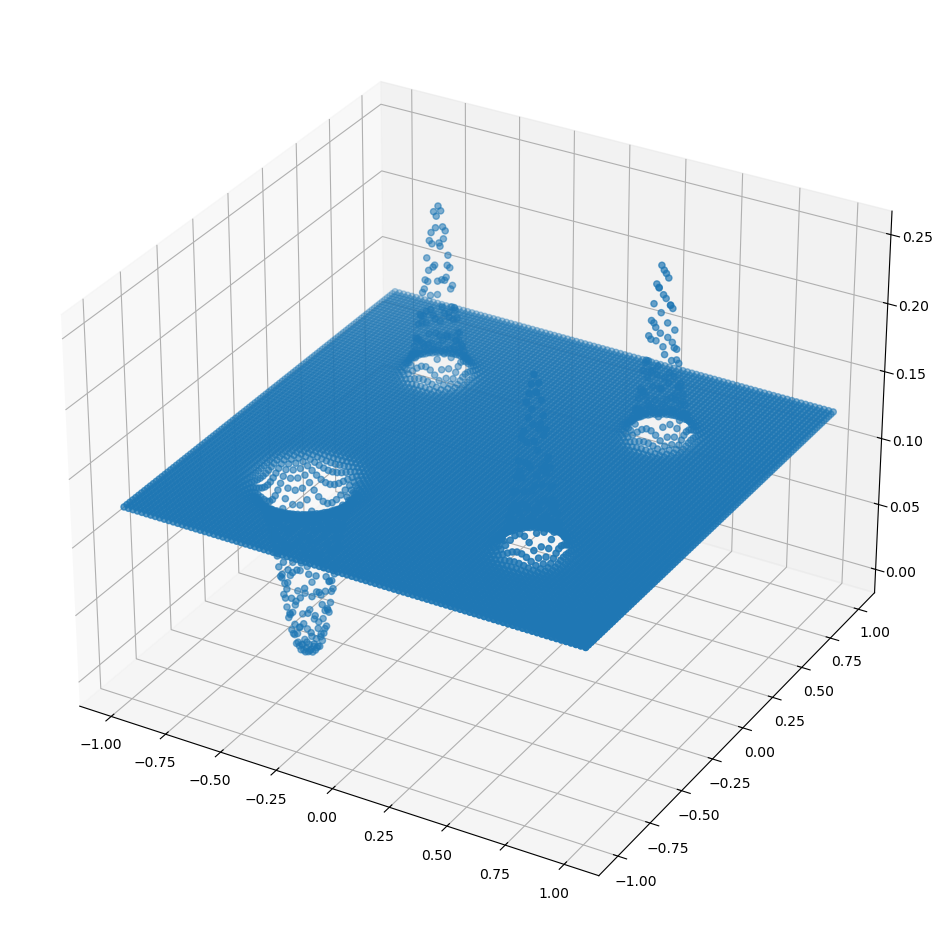

In [1048]:
K = 1
n = 2
sigma = float(data['sigma'])
sigmasquared = sigma**2
true_positions = np.array([[0], [0]])
positions = np.array([[0.5, 0.5], [-0.5, 0.5], [-0.5, -0.5], [0.5, -0.5]]).T
y = np.array([[0], [0], [1], [0]])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
grid = np.array([x_vals, y_vals]).reshape((2, 100**2), order="F")
z_vals = np.zeros((1, 10000))
for i in range(10000):
    z_vals[0, i] = f(grid[:, i].reshape((2, 1), order="F"), positions, y)
z_vals = z_vals.reshape((100, 100), order="F")
ax.scatter(x_vals, y_vals, z_vals)
plt.show()
plt.show()

# Question 6.1

In [1049]:
def d_phi_i_0(x,p_i):
    """
    Computes value of cell i_0 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[0]-x[0])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))

def d_phi_i_1(x,p_i):
    """
    Computes value of cell i_1 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[1]-x[1])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))
    
def d_phi(x, P):
    """
    Computes the jacobian of small phi

    :x: np.ndarray[(1, 2)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2)]
    """
    # Subtract x from each column of P
    diff = P.T - x
    # Compute the squared differences
    squared_diff = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    exp_term = np.exp((-1 / sigmasquared) * squared_diff)
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_phi_0 = (2 / sigmasquared) * diff[:, 0] * exp_term
    d_phi_1 = (2 / sigmasquared) * diff[:, 1] * exp_term
    # Stack the results to form the final array
    d_phi = np.stack((d_phi_0, d_phi_1), axis=1)
    return d_phi

def d_big_phi(X,P):
    """
    Computes the jacobian of big phi

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_big_phi = np.zeros((n**2,2*K))
    for i in range(K):
        d_big_phi[0:n**2,2*i:2*i+2] = d_phi(X[2*i:2*i+2].T,P)
    return d_big_phi

def d_f(X,P):
    """
    Computes the jacobian of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(1, 2K)]
    """
    return (1/n**2)*(bigphi(X,P)-y).T@d_big_phi(X,P)

#compute gradient of f
def grad_f(X,P):
    """
    Computes the gradient of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(2K, 1)]
    """
    return d_f(X,P).T

# Question 6.2

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/1158184851.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data['K'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/1158184851.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data['d'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/1158184851.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data['n'])
/var/folders/zt/35xtgbfd7292

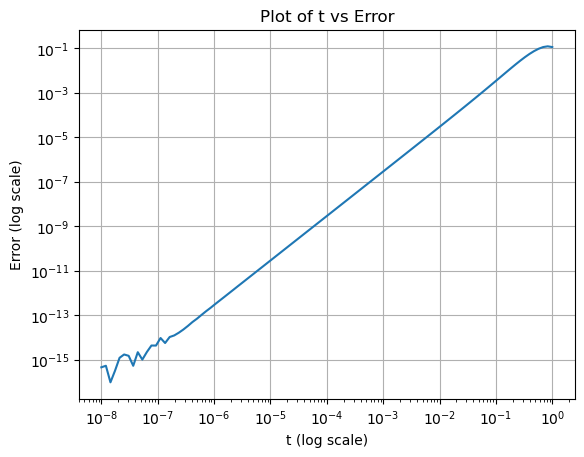

In [1050]:
#checking gradient is correct numerically
K = int(data['K'])
P = data['P']
X0 = data['X0']
d = int(data['d'])
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = int(data['n'])
sigma = float(data['sigma'])
y = data['y'].flatten(order='F').reshape((n**2,1), order="F")

#check that the gradient is correct using
# f(x+tv)= f(x) + t<v,grad_f(x)> + O(t^2)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = v / np.linalg.norm(v)

## Check the gradient 
def checkgradient(f,grad_f, theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=100)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    #compute the error at each t
    for i in tqdm(range(100)):
        error[i] = np.abs( f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad) )
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkgradient(f,grad_f,theta,v)

# Question 7

## Computing the Hessian 

First we re-derive the gradient of f:

$$ f(x) = \frac{1}{2n^2}||\Phi(x) - y ||^2$$

$$ Df(x)[v] = \frac{1}{n^2}< \Phi(x) - y,D \Phi(x)[v] > = \frac{1}{n^2}<(D\Phi(x))^*[\Phi(x) - y],v> $$

$$ \nabla f(x) = \frac{(D\Phi(x))^*[\Phi(x) - y]}{n^2} $$

Then, using the above calculations, we can calculate the hessian:

$$ \frac{1}{n^2}[D((D\Phi(x))^*[\Phi(x) - y])[v]] = \frac{1}{n^2}[D((D\Phi(x))^*[v])[\Phi(x) - y] + (D\Phi(x))^*[D\Phi(x)[v]]]$$


$$ \nabla^2 f(x)[v] = \frac{1}{n^2}[(D(D\Phi(x))^*[v])[\Phi(x)-y]+D\Phi(x)^*[D\Phi(x)[v]]] $$

The implicit reason why we are calculating the hessian with respect to a direction v is because it is computationally much cheaper than to calculate the full hessian which means calculating all 2nd order partial derivatives of f.



In [1051]:
def d_g(x,P,v):
    #subtract x from each column of P
    diff = P.T-x
    # Compute the squared differences
    squared_diff = diff**2
    norm_squared = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    a_1 = np.exp((-1 / sigmasquared) * norm_squared)*(2 / sigmasquared)**2
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_g_1_0 = a_1 *(v[0]*(squared_diff[:,0]-(sigmasquared/2))+v[1]*diff[:,0]*diff[:,1])
    d_g_1_1 = a_1 *(v[1]*(squared_diff[:,1]-(sigmasquared/2))+v[0]*diff[:,0]*diff[:,1])
    # Stack the results to form the final array
    d_g = np.stack((d_g_1_0, d_g_1_1), axis=1)
    return d_g
    


def d_d_phi(X, P, V):
    """
    Compute the directional derivative of the Jacobian of phi at x in the direction v.

    :param X: np.ndarray[(1, 2K)] "position of a stat"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param V: np.ndarray[(1, 2K)] "vector direction of change in star position"
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_d_phi = np.zeros((n**2,2*K))
    for i in range(K):
            d_d_phi[0:n**2,2*i:2*i+2] = d_g(X[2*i:2*i+2].T,P,V[2*i:2*i+2])
    return d_d_phi
    


def hessian_f(X,V):
    """
    Compute the Hessian of f at X in the direction v.
    
    :param X: np.ndarray[(1, 2K)] "position of K stars"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param y: np.ndarray[(n**2, 1)] "actual image detected, y = Phi(X_true)" remember we want to find X_true
    :param v: np.ndarray[(2, K)] "direction at which hessian is taken" 
    :returns: np.ndarray[(2*K, 1)]
    """
    # Compute intermediate terms
    phi_X = bigphi(X, P) - y  # (n**2, 1)
    d_big_phi_X = d_big_phi(X, P)  # (n**2, 2*K)
    d_big_phi_X_v = d_big_phi_X @ V  # directional derivative of big_phi in direction v

    # Compute each term in the Hessian formula

    term1 = d_d_phi(X, P, V).T @ phi_X 
    term2 = d_big_phi_X.T @ d_big_phi_X_v 

    hessian = (1 / n**2) * (term1 + term2)
    return hessian



# Question 8


  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/1214918749.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
100%|██████████| 100/100 [00:05<00:00, 17.16it/s]


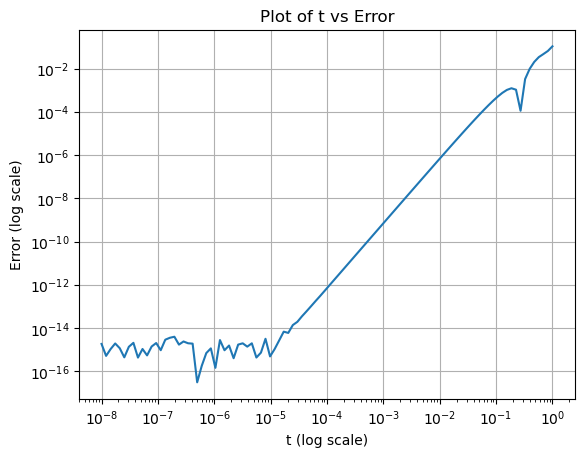

In [1052]:
X_random = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")  # Random X
U_random = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")  # Random direction U
U_random /= np.linalg.norm(U_random)  # Normalize U

#check that the gradient is correct using
# f(x+tv)= f(x) + t<v,grad_f(x)> + t^2/2*v.T@hess_f(x)[v] + O(t^3)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape((d*K,1), order="F")
v = v / np.linalg.norm(v)

## Check the hessian 
def checkhessian(f,grad_f,hessian_f,theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=100)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    f_lambda_hess_v = hessian_f(theta,v)
    #compute the error at each t
    for i in tqdm(range(100)):
        error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkhessian(f,grad_f,hessian_f,theta,v)

# Question 9

In [1053]:
def truncated_conjugate_gradient(b: np.array, radius: float, x0) -> tuple:
    """
    Solve the trust-region subproblem using the Truncated Conjugate Gradient (tCG) method.

    :param b: np.array[(2, K)] - The gradient vector reshaped as a 2D array
    :param radius: float - The trust-region radius for constraint
    :param x0: Initial guess or parameter for Hessian computation
    :returns: tuple (solution vector, residual vector, bool flag) where:
              - The solution vector has shape (2*K, 1),
              - The residual vector indicates the end of iterations, and
              - A boolean flag shows whether the radius constraint was active.
    """

    # Flatten b to make it a column vector of shape (2*K, 1) for matrix operations.
    b = b.reshape((-1, 1), order="F")
    v0 = np.zeros((2 * K, 1))  # Initial solution vector
    r0 = b.copy()              # Residual vector initialized to b
    p0 = b.copy()              # Search direction initialized to b

    for i in range(5):
        Hp = hessian_f(x0, p0)
        
        # Calculate alpha (step size) as the ratio of r0.T @ r0 and p0.T @ Hp
        inner_pHp = (p0.T @ Hp)[0, 0]  # Inner product of p0 and Hp as scalar
        alpha = (r0.T @ r0)[0, 0] / inner_pHp

        # Compute potential next solution vector v_plus
        v_plus = v0 + alpha * p0
        
        # Check trust-region radius constraint and whether the problem is solved
        if inner_pHp <= 0 or np.linalg.norm(v_plus) >= radius:
            # If radius constraint is active, calculate step size `t` for v0 to satisfy ||v0|| = radius
            inner_pv = (v0.T @ p0)[0, 0]
            norm2_p = (p0.T @ p0)[0, 0]
            discriminant = inner_pv**2 - ((v0.T @ v0)[0, 0] - radius**2) * norm2_p
            t = (-inner_pv + np.sqrt(discriminant)) / norm2_p
            
            # Adjust v0 to be on the boundary and return solution
            v0 += t * p0
            return (v0, b - r0 + t * Hp, True)  # Radius constraint was active, flag is True
        
        # Otherwise, update the solution vector
        v0 = v_plus
        r_old = r0.copy()  # Save current residual to compute beta
        r0 -= alpha * Hp   # Update residual

        # Check for convergence based on residual norm
        if np.linalg.norm(r0) <= np.linalg.norm(b) * min(np.linalg.norm(r0), 0.1):
            return (v0, b - r0, False)  # Converged within trust-region, flag is False
        
        # Update beta for next conjugate direction
        beta0 = (r0.T @ r0)[0, 0] / (r_old.T @ r_old)[0, 0]
        
        # Update search direction p0
        p0 = r0 + beta0 * p0
    
    return (v0, b - r0, False)  # Return solution and residual; flag is False as radius was not active

# Question 10

In [1054]:
def trust_region_method(x0, max_radius, delta_0, rho_prime=0.1, max_iters=30):
    """
    Trust Region Method using a quadratic model and truncated conjugate gradient.

    :param x0: Initial point for the optimization (numpy array).
    :param gradient_func: Function to compute the gradient at a point `x`.
    :param hessian_func: Function to compute the Hessian matrix at a point `x`.
    :param max_radius: Maximum allowable radius for the trust region.
    :param delta_0: Initial radius for the trust region.
    :param rho_prime: Threshold for accepting a step based on actual-to-model reduction ratio.
    :param max_iters: Maximum number of iterations for the trust region algorithm.
    
    :returns: The optimized point `x` and a list of gradient norms for each iteration.
    """
    x = x0.copy().flatten(order='F').reshape(d*K,1)
    delta = delta_0
    gradient_norms = []
    initial_time = time.time()
    time_array = [] 
    for k in tqdm(range(max_iters)):
        grad = grad_f(x,P)
        grad_norm = np.linalg.norm(grad)
        gradient_norms.append(grad_norm)  # Store the gradient norm
        time_array.append(time.time()-initial_time)

        if grad_norm <= 1e-20:
            print("Gradient close to zero, stopping optimization.")
            break
        
        # Inner truncated CG with delta as the maximum allowable step
        u_k,Hu_k,flag = truncated_conjugate_gradient(-grad, delta,x)
        x_plus = x + u_k
        
        # Calculate the actual and model reductions
        actual_reduction = f(x,P,y) - f(x_plus,P,y)
        model_reduction = -grad.T @ u_k - 0.5 * u_k.T @ Hu_k
        
        # Compute the ratio of actual to model improvement
        rho_k = actual_reduction / (model_reduction)  # Avoid division by zero

        # Accept or reject the tentative next iterate
        if rho_k > rho_prime:
            x = x_plus  # Accept the step
        else:
            x = x  # Reject the step 

        # Update the trust-region radius based on rho_k
        if rho_k < 0.25:
            delta = 0.25 * delta
        elif rho_k > 0.75 and flag:
            delta = min(2 * delta, max_radius)
        else:
            delta = delta
    return x.reshape((2, K), order="F"), gradient_norms, time_array

# Question 11
Run the trust-region algorithm with truncated-CG on data-toy.mat starting from the initial point x0 provided in the dataset.

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/3367363827.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data_toy['K'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/3367363827.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data_toy['d'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/3367363827.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data_toy['n'])
/var/folders/

Positions we found


100%|██████████| 30/30 [00:00<00:00, 551.41it/s]


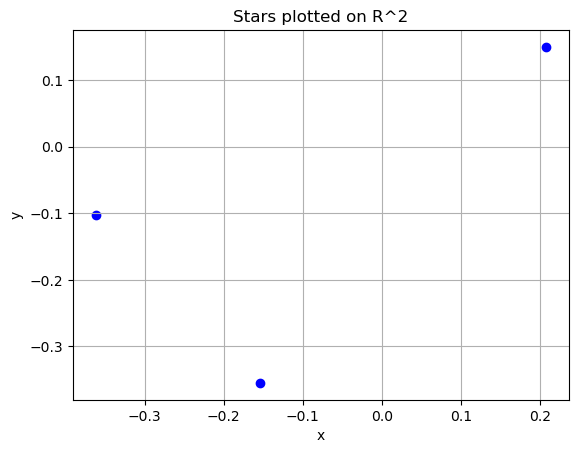

What was observed from positions we found


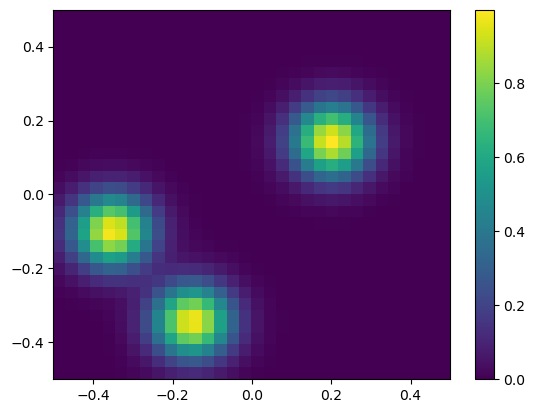

What was observed from real positions


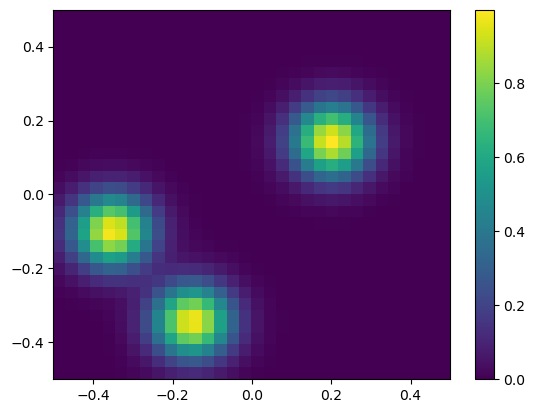

In [1055]:
def plotting_stars(Random_intial_point:np.array = X0, Delta0: float = delta_0, DeltaBar: float = np.sqrt(6),  rhoPrime: float=0.1):
    """
    usual input: random initial starting point for Trsolver, usually taken to be given by the dataset

    :param Delta0: float
    :param DeltaBar: float
    :param rhoPrime: float
    :param tol: float
    param time_limit: float
    """
    
    # x0 = X0.flatten(order='F').reshape(d*K,1) #x0 
    points = trust_region_method(Random_intial_point, DeltaBar, Delta0, rhoPrime, max_iters=30)[0]

    # Separate x and y coordinates for plotting
    x = points[0,:]
    y = points[1,:]

    # Create the scatter plot
    plt.scatter(x, y, color='blue', marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Stars plotted on R^2')
    plt.grid(True)
    plt.show()



def plotimage(X):
    """
    Plots the image of matrix X with a colorbar.
    
    Parameters:
    X : 2D array-like
        Input matrix to be plotted.
    """
    X = np.array(X)
    m, n = X.shape
    if m != n:
        print("Warning: plotimage - Input matrix is not square.")
    
    x = np.linspace(-0.5, 0.5, m)
    y = np.linspace(-0.5, 0.5, n)
    
    plt.figure()
    plt.imshow(X, extent=[x[0], x[-1], y[0], y[-1]], aspect='equal', origin='lower')
    plt.colorbar()
    plt.axis('tight')
    plt.draw()
    plt.show()


#test with X0 given for data toy
#checking gradient is correct numerically
K = int(data_toy['K'])
P = data_toy['P']
X0 = data_toy['X0']
d = int(data_toy['d'])
delta_0 = data_toy['delta_0']
delta_bar = data_toy['delta_bar']
n = int(data_toy['n'])
sigma = float(data_toy['sigma'])
y = data_toy['y'].flatten(order='F').reshape((n**2,1), order="F")

solution,grad_norms5,times = trust_region_method(data_toy['X0'],delta_bar, delta_0)
print("Positions we found")
plotting_stars(data_toy['X0'])
print("What was observed from positions we found")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))
print("What was observed from real positions")
plotimage(y.reshape((n,n), order="F"))




# Question 12
Run the trust-region method several times on data.mat with different random initial points.

Hypothesis before having run the code: Since the function is non-convex, the trust-region algorithm might converge to different local minima depending on the initial point, leading to varying objective values across runs. If the stars in the dataset are well-separated (like in toy data sets), the results might be more consistent as the algorithm converges near true positions. However, for data.mat, where stars are closer and configurations more complex, we're more likely to see variability in the objective values due to multiple plausible configurations.

/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/2216717038.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data['K'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/2216717038.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data['d'])
/var/folders/zt/35xtgbfd7292xj15zysfwntc0000gn/T/ipykernel_41272/2216717038.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data['n'])
/var/folders/zt/35xtgbfd7292

What was observed from found positions with starting random point 1


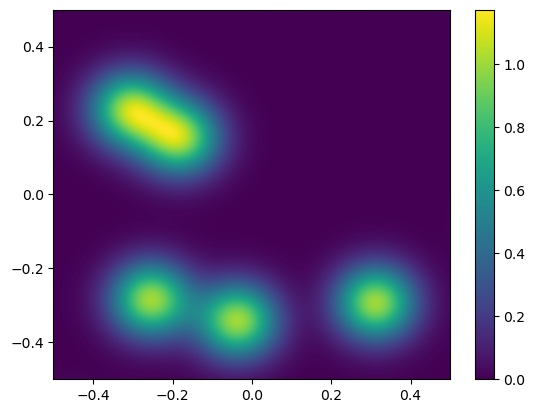

100%|██████████| 30/30 [00:36<00:00,  1.20s/it]

What was observed from found positions with starting random point 2


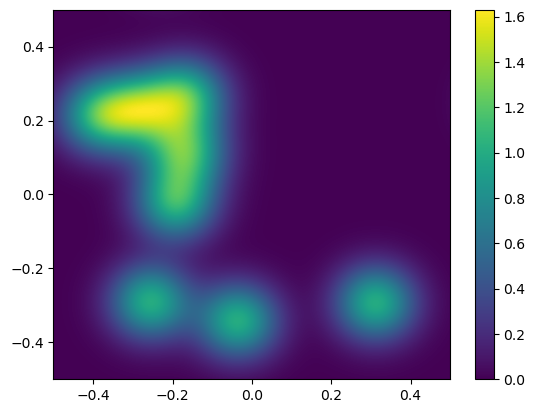

100%|██████████| 30/30 [00:37<00:00,  1.26s/it]

What was observed from found positions with starting random point 3


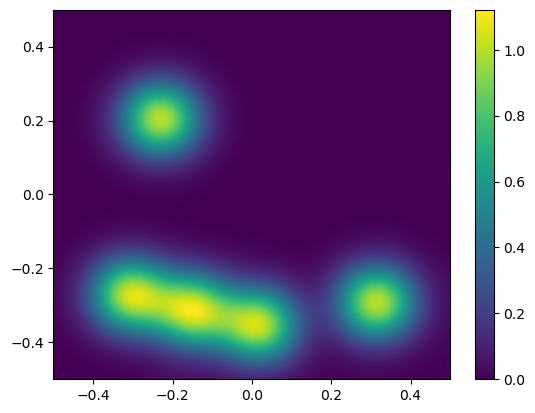

What was observed from real positions


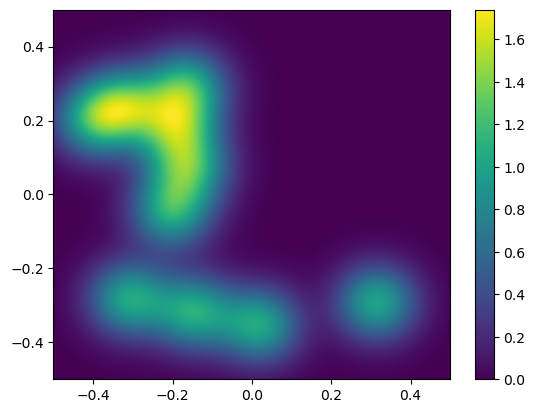

In [1056]:
#checking gradient is correct numerically
K = int(data['K'])
P = data['P']
X0 = data['X0']
d = int(data['d'])
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = int(data['n'])
sigma = float(data['sigma'])
y = data['y'].flatten(order='F').reshape((n**2,1), order="F")

#test with random point 1
x_random1 = np.random.uniform(-0.5, 0.5, (d, K))
solution,grad_norms5,times = trust_region_method(x_random1,delta_bar, delta_0)
print("What was observed from found positions with starting random point 1")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))

#test with random point 2
x_random2 = np.random.uniform(-0.5, 0.5, (d, K))
solution,grad_norms5,times = trust_region_method(x_random2,delta_bar, delta_0)
print("What was observed from found positions with starting random point 2")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))

#test with random point 3
x_random3 = np.random.uniform(-0.5, 0.5, (d, K))
solution,grad_norms5,times = trust_region_method(x_random3,delta_bar, delta_0)
print("What was observed from found positions with starting random point 3")
plotimage(bigphi(solution.reshape((2, K), order="F"),P).reshape((n,n), order="F"))

print("What was observed from real positions")
plotimage(y.reshape((n,n), order="F"))


# Question 13
Run the trust-region algorithm on data.mat starting from the point x0 provided in thedataset.

Plot the norm of the gradient ∥∇f(xk)∥ as a function of k (gradient norm always on a log-scale). Do the same thing as a function of computation time.

100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


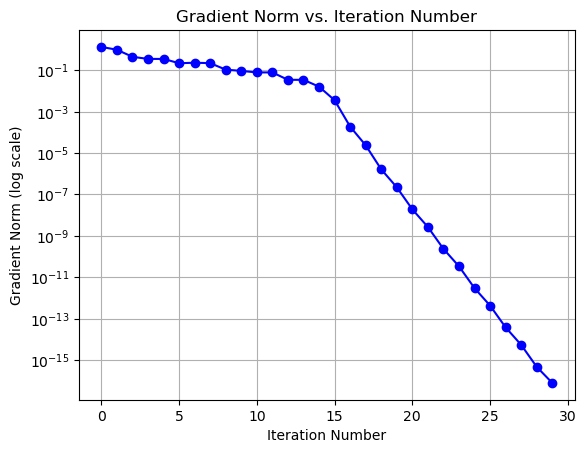

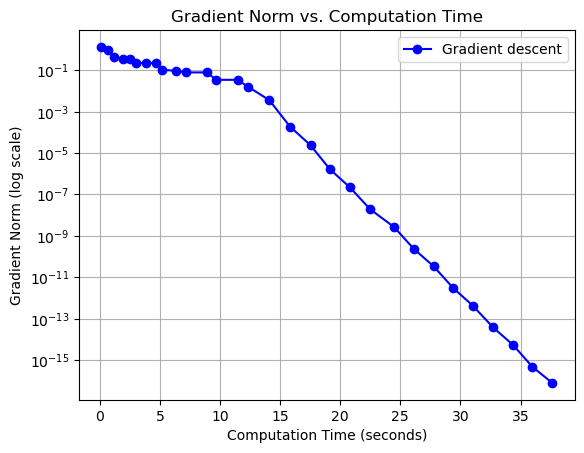

In [1057]:
# plotting function for gradient norm vs iteration number
def plot_gradient_norm_iterations(gradient_norms:np.ndarray):
    plt.plot(gradient_norms, marker='o', linestyle='-', color='b')
    plt.title("Gradient Norm vs. Iteration Number") # need to maybe change this to a different title ###################
    plt.xlabel("Iteration Number")
    plt.ylabel("Gradient Norm (log scale)")
    plt.yscale('log')
    plt.grid()
    plt.show()

# plotting function for gradient norm vs iteration number
def plot_gradient_norm_time(gradient_norms1: list, time_array1: list):
    plt.plot(time_array1, gradient_norms1, marker='o', linestyle='-', color='b', label='Gradient descent')
    plt.title("Gradient Norm vs. Computation Time")
    plt.xlabel("Computation Time (seconds)")
    plt.ylabel("Gradient Norm (log scale)")
    plt.yscale('log')
    plt.grid()
    plt.legend() 
    plt.show()

#test with X0 given
solution,grad_norms,time_array = trust_region_method(X0,delta_bar, delta_0)
plot_gradient_norm_iterations(grad_norms)
plot_gradient_norm_time(grad_norms,time_array)
